In [54]:
!pip install keras

In [ ]:
!pip install tensorflow

In [88]:
import os

import random
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image



In [89]:
from tensorflow import keras

In [90]:
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
'''
Create a convolutional neural network model(CNN) :
With one separate input layer, three convolutional layers and a maximum pooling layer
'''

model = Sequential()

model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattenning 3D feature maps into 1D vectors
model.add(Flatten())

# Add full connectivity layer
model.add(Dense(512, activation='relu'))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Output layer, outputs classification results(there are 15 dog breed categories)
model.add(Dense(15, activation='softmax'))

# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Printed Model Structures
# model.summary()
#return model

In [61]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.show()

In [91]:
#def train(train_dir, valid_dir, batch_size, epochs):

train_dir = '/content/drive/MyDrive/archive/train'
valid_dir = '/content/drive/MyDrive/archive/valid'
batch_size = 128
epochs = 10

# Preprocessing and enhancement of training and validation data
train_datagen = ImageDataGenerator(
            rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Generating data streams for training and validation sets
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical'
        )

valid_generator = valid_datagen.flow_from_directory(
            valid_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical'
        )

# Training the model
train_history = model.fit(
            train_generator,
            steps_per_epoch=min(train_generator.samples // batch_size, 150),
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=valid_generator.samples // batch_size,
        )



Found 1714 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Epoch 1/10
13/13 [==============================] - 23s 2s/step - loss: 0.3298 - accuracy: 0.8947 - val_loss: 1.9501 - val_accuracy: 0.5156
Epoch 2/10
13/13 [==============================] - 23s 2s/step - loss: 0.3096 - accuracy: 0.9079 - val_loss: 1.6424 - val_accuracy: 0.5703
Epoch 3/10
13/13 [==============================] - 22s 2s/step - loss: 0.2913 - accuracy: 0.8947 - val_loss: 1.6685 - val_accuracy: 0.5703
Epoch 4/10
13/13 [==============================] - 22s 2s/step - loss: 0.2827 - accuracy: 0.9086 - val_loss: 1.7867 - val_accuracy: 0.5625
Epoch 5/10
13/13 [==============================] - 22s 2s/step - loss: 0.2804 - accuracy: 0.9048 - val_loss: 1.5358 - val_accuracy: 0.5859
Epoch 6/10
13/13 [==============================] - 22s 2s/step - loss: 0.3024 - accuracy: 0.9004 - val_loss: 1.7617 - val_accuracy: 0.5312
Epoch 7/10
13/13 [==============================] - 22s 2s/step - loss: 0.2

In [95]:
# Calculating accuracy
scores = model.evaluate(
            valid_generator, steps=valid_generator.samples // batch_size)
validation_accuracy = scores[1] * 100

print("\nValid set Accuracy: %.2f%%\n" % validation_accuracy)

1/1 [==============================] - 1s 645ms/step - loss: 1.6464 - accuracy: 0.5781

Valid set Accuracy: 57.81%



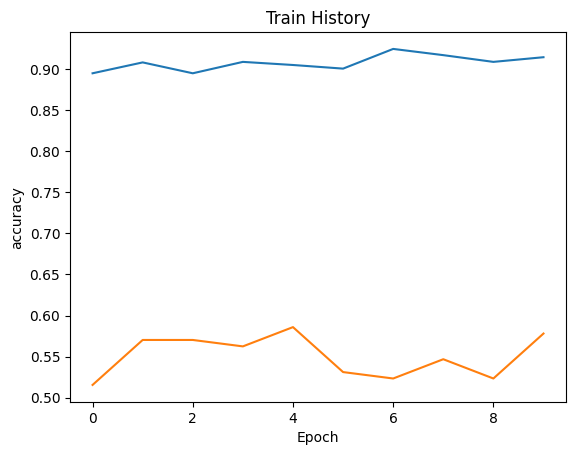

In [96]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

In [65]:
def center_crop_image(img):
  '''
  Pre-processing of images, with different sized images as input,
          and centered cropped images as output.
  '''

  width, height = img.size
  new_width = new_height = min(width, height)
  left = (width - new_width) // 2
  top = (height - new_height) // 2
  right = (width + new_width) // 2
  bottom = (height + new_height) // 2

  return img.crop((left, top, right, bottom))

In [66]:
def get_predicted_breed(self, predictions):
  '''
  To get the dog breed name based on the model predictions,
  assume that predictions is the result of the model's prediction of the image,
  determine the predicted breed based on the index of the highest probability in the probability vector
  '''

  class_names = ["Airedale", "Beagle", "Bloodhound", "Bluetick", "Chihuahua", "Collie", "Dingo",
                            "French Bulldog", "German Sheperd", "Malinois", "Newfoundland", "Pekinese",
                            "Pomeranian", "Pug", "Vizsla"]

  breed_index = predictions.argmax()
  breed_name = class_names[breed_index]

  return breed_name

In [67]:
def test(test_dir):

  # Getting test set file address
  test_files = os.listdir(test_dir)
  # To be fair, the order of access is randomized.
  random.shuffle(test_files)

  test_results = []

  for file_name in test_files:

    # Load image with center crop and preprocessing
    img_path = os.path.join(test_dir, file_name)
    img = Image.open(img_path)
    # Center Cropped Image
    img = center_crop_image(img)
    # resize
    img = img.resize((224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Making predictions about the image
    predictions = model.predict(img_array)
    predicted_breed = get_predicted_breed(predictions)

    test_results.append((file_name, predicted_breed))

    # Output results into Excel(no need title)
    df = pd.DataFrame(test_results, columns=[
                          'File Name', 'Predicted Breed'])
    df.to_excel('test_data.xlsx', index=False, header=False)

    #s = "Test results saved to test_data.xlsx"
    #s

In [68]:
def main():
    train_dir = '/content/drive/MyDrive/archive/train'
    valid_dir = '/content/drive/MyDrive/archive/valid'
    test_dir = '/content/drive/MyDrive/archive/testing_set'
    batch_size = 32
    epochs = 10

    #build_model()
    #train(train_dir, valid_dir, batch_size, epochs)
    #evaluate(valid_dir, batch_size)
    #test(test_dir)


if __name__ == "__main__":
    main()

In [69]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 12 16:58:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              40W / 300W |  15126MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--